## Look at BLING output

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pickle
from mpl_toolkits.basemap import Basemap, cm
import cmocean

%matplotlib inline

In [15]:
# BLING:

folder_EPM101 = '/data/brogalla/ANHA4/BLING-EPM101/'
folder_EPM102 = '/data/brogalla/ANHA4/BLING-EPM102/'

dset = xr.open_dataset(folder_EPM101+'ANHA4-EPM101_y2002m08d13_gridB.nc')
ANHA4_lons = dset['nav_lon'].values
ANHA4_lats = dset['nav_lat'].values
ANHA4_depths = dset['deptht'].values

file_range = ['ANHA4-EPM101_y2002m08d18_gridB.nc', 'ANHA4-EPM101_y2002m08d23_gridB.nc', 'ANHA4-EPM101_y2002m08d28_gridB.nc', \
              'ANHA4-EPM101_y2002m09d02_gridB.nc', 'ANHA4-EPM101_y2002m09d07_gridB.nc', 'ANHA4-EPM101_y2002m09d12_gridB.nc', \
              'ANHA4-EPM101_y2002m09d17_gridB.nc', 'ANHA4-EPM101_y2002m09d22_gridB.nc', 'ANHA4-EPM101_y2002m09d27_gridB.nc', \
              'ANHA4-EPM101_y2002m10d02_gridB.nc', 'ANHA4-EPM101_y2002m10d07_gridB.nc']

biomass_p = np.zeros((50,800,544))
zflux_pop = np.zeros((50,800,544))
for n,file in enumerate(file_range):
    dset = xr.open_dataset(folder_EPM101+file)
    biomass_p = biomass_p + dset['biomass_p'][0,:,:,:].drop(labels=['time_centered', 'time_counter']).values
    zflux_pop = zflux_pop + dset['jp_pop'] [0,:,:,:].drop(labels=['time_centered', 'time_counter']).values
    
biomass = biomass_p / n
zflux   = zflux_pop / n 

In [7]:
# Kadko et al., 2018: collected August 20 - October 5, 2015
kadko_lats   = np.array([76.511, 79.997, 83.755, 87.520, 88.407, 89.987, 87.815, 85.135, 82.491, 80.369, 78.180, 77.503, 76.998, \
                76.505, 73.506, 73.008])
kadko_lons   = np.array([-173.034, -174.962, 174.915, -179.809, -176.761, -89.25, -149.734, -150.063, -149.872, -149.855, -147.831, -148.009, -148.803, \
               -149.515, -156.808, -158.729])
kadko_depths = np.array([56, 52, 52, 46, 20, 23, 45, 41, 47, 49, 40, 47, 40, 40, 46, 36])
kadko_res    = np.array([0.69, 0.76, 0.94, 0.24, 0.76, 0.27, 0.33, 0.71, 1.07, 0.65, 0.31, 0.36, 0.41, 0.28, 0.38, 0.18])

In [8]:
# Chen et al., 2012: 
chen_lats   = np.array([69.996, 73.998, 68.919, 70.495, 71.579, 71.261, 73.995, 73.380])
chen_lons   = np.array([-168.999, -168.991, -167.009, -162.976, -164.013, -150.376, -156.332, -151.883])
chen_depths = np.array([30, 40, 10, 30, 40, 20, 30, 100])
chen_res    = np.array([0.05, 0.10, 0.01, 0.15, 0.03, 0.10, 0.23, 0.28])

In [18]:
def plot_slicemap(variable, depth_slice, cmap=cmocean.cm.matter):
    fig, ax, proj = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/pb-surface.pickle','rb'))

    x, y = proj(ANHA4_lons, ANHA4_lats)

    cb = proj.contourf(x, y, variable[depth_slice,:,:], cmap=cmocean.cm.matter)
    
    x_kadko, y_kadko = proj(kadko_lons, kadko_lats)
    proj.scatter(x_kadko, y_kadko, c=kadko_res, cmap=cmocean.cm.haline, s=160, edgecolor='k', vmin=0, vmax=0.6)
    
    x_chen, y_chen = proj(chen_lons, chen_lats)
    cb2 = proj.scatter(x_chen, y_chen, c=chen_res, cmap=cmocean.cm.haline, s=160, edgecolor='w', vmin=0, vmax=0.6)

    cbaxes  = fig.add_axes([0.95, 0.15, 0.02, 0.7]) 
    cbaxes2 = fig.add_axes([0.15, 0.15, 0.02, 0.3]) 
    CBar    = plt.colorbar(cb , ax=ax, cax=cbaxes, format='%.2e') 
    CBar2   = plt.colorbar(cb2, ax=ax, cax=cbaxes2, format='%.2f') 
    CBar.ax.tick_params(axis='y', length=0, labelsize=14)
    CBar2.ax.tick_params(axis='y', length=0, labelsize=14)
#     CBar.set_label(variable.attrs['long_name']+', '+variable.attrs['units'], fontsize=16)
    CBar.set_label('Biomass', fontsize=16)
    CBar2.set_label('Residence time [yr]', fontsize=16)
    
    return

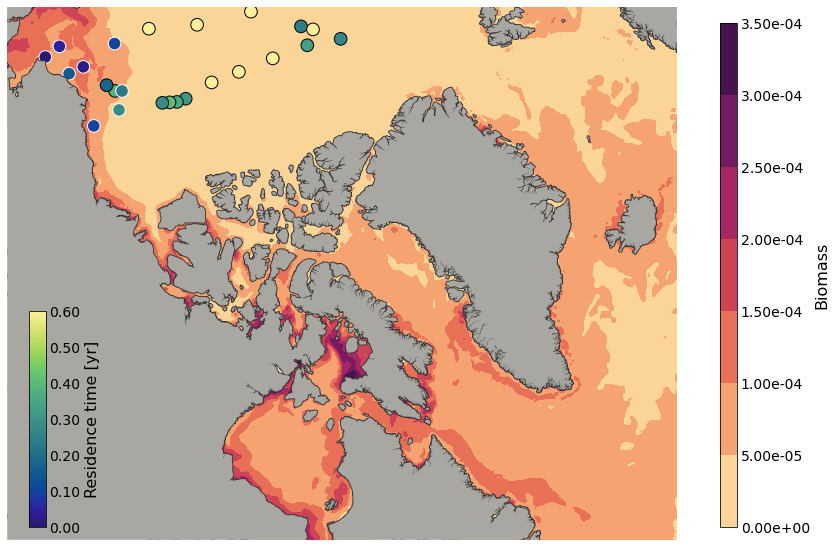

In [19]:
plot_slicemap(biomass, 0)

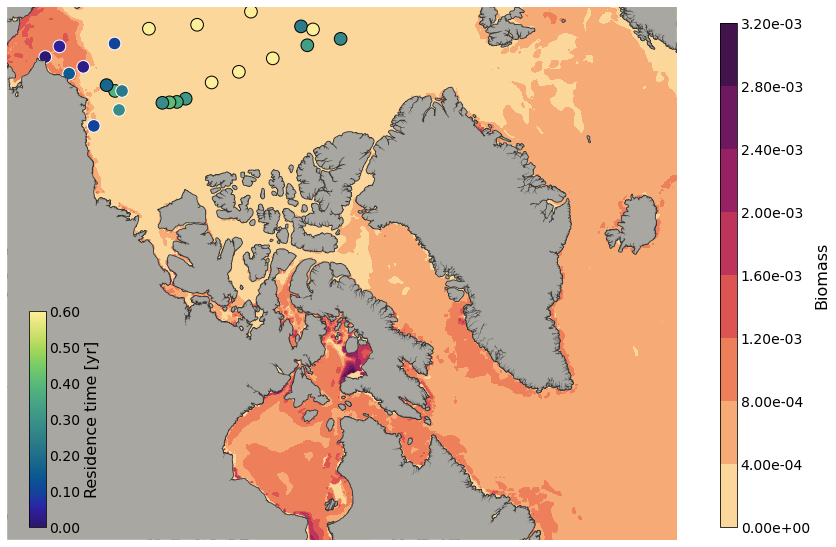

In [20]:
plot_slicemap(biomass_p, 10)

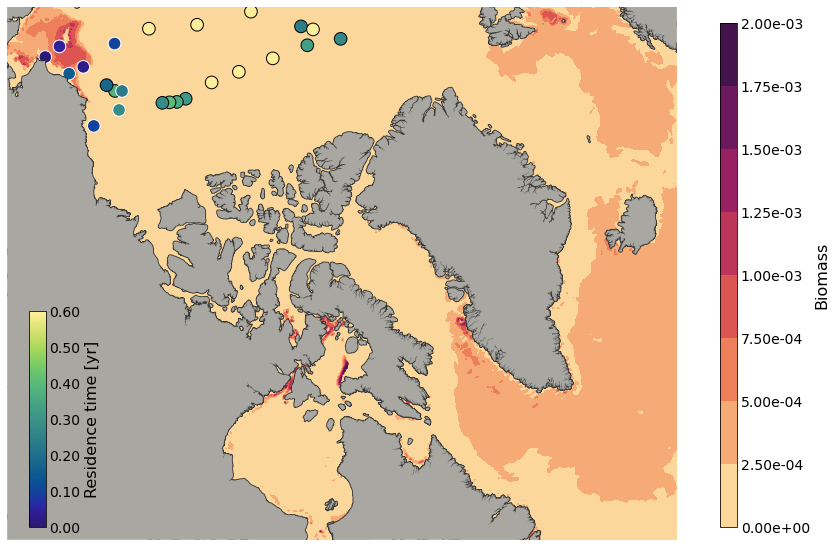

In [21]:
plot_slicemap(biomass_p, 15)

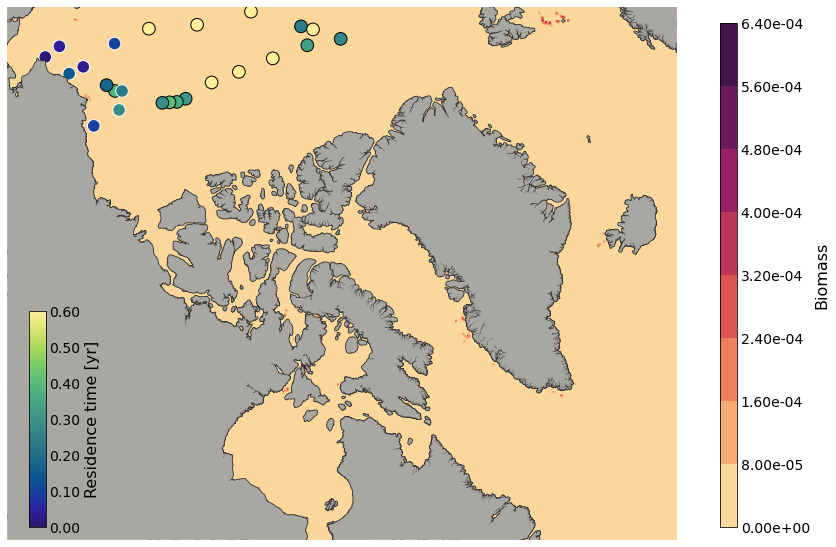

In [22]:
plot_slicemap(biomass_p, 20)